The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [23]:
!pip install d2l==0.15.0


# Concise Implementation of Softmax Regression
:label:`sec_softmax_concise`

Just as high-level APIs of deep learning frameworks
made it much easier
to implement linear regression in :numref:`sec_linear_concise`,
we will find it similarly (or possibly more)
convenient for implementing classification models. Let us stick with the Fashion-MNIST dataset
and keep the batch size at 256 as in :numref:`sec_softmax_scratch`.


In [223]:
from d2l import torch as d2l
import numpy as np
import torch
from torch import nn

import cv2

import torchvision
from torchvision import transforms
from torchvision import datasets

from torch.utils import data
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#%matplotlib inline
#import torchvision
#from torchvision import transforms
#from torch.utils import data

#d2l.use_svg_display()

In [224]:
#import os
#os.chdir('/Users/dmitryi/Documents/GitHub/')  
img_folder_path = r'/Users/dmitryi/Documents/GitHub/data/images'

In [225]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = cv2.imread(img_loc)#Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [515]:
class Renorm(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image = sample/-sample.max()+1
        return image

In [516]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1

my_trans = transforms.Compose([transforms.Resize((28,28)),
                               transforms.Grayscale(num_output_channels=1),
                               Renorm(),
                               transforms.ToTensor(), 
                               transforms.Normalize((0.1307,), (0.3081,))
                              ])

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)

my_dataset = datasets.ImageFolder(root=img_folder_path,
                                           transform=my_trans)

#my_dataset = CustomDataSet(img_folder_path, transform=trans)

In [299]:
len(mnist_train), len(mnist_test), len(my_dataset)

(60000, 10000, 10)

In [300]:
batch_size = 256

def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [367]:
def load_data_mnist(batch_size, resize=None):  #@save
    """Download the MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers())
           )

In [302]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size) #d2l.load_data_mnist(batch_size)

In [514]:
batch_size2 = 1

def load_dataset(batch_size, resize=None):  #@save
    
    my_trans = transforms.Compose([transforms.Resize((28,28)),
                                   transforms.Grayscale(num_output_channels=1),
                                   Renorm(),
                                   transforms.ToTensor(), 
                                   transforms.Normalize((0.1307,), (0.3081,))
                                  ])
    #if resize:
    #    my_trans.insert(0, transforms.Resize(resize))
    #my_trans = transforms.Compose(my_trans)
    my_dataset = datasets.ImageFolder(root=img_folder_path, transform=my_trans)
    return (
            data.DataLoader(my_dataset, batch_size2, shuffle=False)
           )

## Initializing Model Parameters

As mentioned in :numref:`sec_softmax`,
the output layer of softmax regression
is a fully-connected layer.
Therefore, to implement our model,
we just need to add one fully-connected layer
with 10 outputs to our `Sequential`.
Again, here, the `Sequential` is not really necessary,
but we might as well form the habit since it will be ubiquitous
when implementing deep models.
Again, we initialize the weights at random
with zero mean and standard deviation 0.01.


In [304]:
# PyTorch does not implicitly reshape the inputs. Thus we define a layer to
# reshape the inputs in our network
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,784)

net = nn.Sequential(Reshape(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## Softmax Implementation Revisited
:label:`subsec_softmax-implementation-revisited`

In the previous example of :numref:`sec_softmax_scratch`,
we calculated our model's output
and then ran this output through the cross-entropy loss.
Mathematically, that is a perfectly reasonable thing to do.
However, from a computational perspective,
exponentiation can be a source of numerical stability issues.

Recall that the softmax function calculates
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$,
where $\hat y_j$ is the $j^\mathrm{th}$ element of
the predicted probability distribution $\hat{\mathbf{y}}$
and $o_j$ is the $j^\mathrm{th}$ element of the logits
$\mathbf{o}$.
If some of the $o_k$ are very large (i.e., very positive),
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types (i.e., *overflow*).
This would make the denominator (and/or numerator) `inf` (infinity)
and we wind up encountering either 0, `inf`, or `nan` (not a number) for $\hat y_j$.
In these situations we do not get a well-defined
return value for cross-entropy.


One trick to get around this is to first subtract $\max(o_k)$
from all $o_k$ before proceeding with the softmax calculation.
You can verify that this shifting of each $o_k$ by constant factor
does not change the return value of softmax.
After the subtraction and normalization step,
it might be possible that some $o_j$ have large negative values
and thus that the corresponding $\exp(o_j)$ will take values close to zero.
These might be rounded to zero due to finite precision (i.e., *underflow*),
making $\hat y_j$ zero and giving us `-inf` for $\log(\hat y_j)$.
A few steps down the road in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `nan` results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining these two operators
softmax and cross-entropy together,
we can escape the numerical stability issues
that might otherwise plague us during backpropagation.
As shown in the equation below, we avoid calculating $\exp(o_j)$
and can use instead $o_j$ directly due to the canceling in $\log(\exp(\cdot))$.

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j)}{\sum_k \exp(o_k)}\right) \\
& = \log{(\exp(o_j))}-\log{\left( \sum_k \exp(o_k) \right)} \\
& = o_j -\log{\left( \sum_k \exp(o_k) \right)}.
\end{aligned}
$$

We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we will just pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function,
which does smart things like the ["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp).


In [309]:
loss = nn.CrossEntropyLoss()

## Optimization Algorithm

Here, we use minibatch stochastic gradient descent
with a learning rate of 0.1 as the optimization algorithm.
Note that this is the same as we applied in the linear regression example
and it illustrates the general applicability of the optimizers.


In [310]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## Training

Next we call the training function defined in :numref:`sec_softmax_scratch` to train the model.


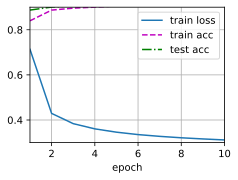

In [311]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [236]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [237]:
len(train_iter)

235

In [53]:
len(mnist_train)/len(train_iter)

255.31914893617022

In [345]:
mnist_test[0][0].shape

torch.Size([1, 28, 28])

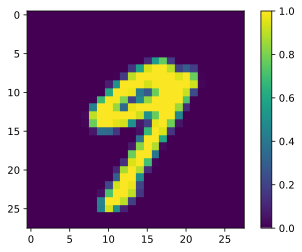

In [487]:
plt.imshow(mnist_test[20][0][0])
plt.colorbar()

In [313]:
q=net.forward(mnist_test[200][0][0])
torch.argmax(F.softmax(q, dim=-1))

tensor(7)

In [484]:
my_dataset[0][0].shape

torch.Size([1, 28, 28])

In [517]:
plt.imshow(my_dataset[9][0][0])#imshow(my_dataset[9][0][0]/-my_dataset[9][0][0].max() +1)
plt.colorbar()
z=net.forward(my_dataset[9][0][0])
torch.argmax(F.softmax(z, dim=-1))

AttributeError: 'Image' object has no attribute 'max'

In [336]:
z=net.forward(my_dataset[9][0][0])
torch.argmax(F.softmax(z, dim=-1))

tensor(1)

In [192]:
net.forward(my_dataset[9][0][0])

tensor([[-0.1308, -0.0075, -0.0258, -0.1561,  0.3909, -0.0633,  0.0518,  0.1426,
         -0.0017,  0.0770]], grad_fn=<AddmmBackward>)

In [495]:
trans = [transforms.ToTensor()]
trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)

mean = torch.mean(mnist_train.data.float() / 255.0)
std = torch.std(mnist_train.data.float()/ 255.0)

mean,std

(tensor(0.1307), tensor(0.3081))

In [502]:
mean = torch.mean(my_dataset[9][0][0].data.float())
std = torch.std(my_dataset[9][0][0].data.float())

mean,std

(tensor(0.8357), tensor(0.4202))

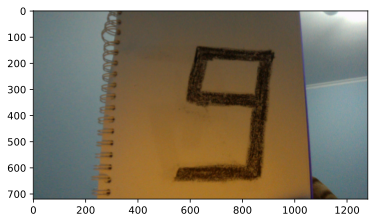

In [496]:
#Открываю, то что сохранил
img = cv2.imread('/Users/dmitryi/Documents/GitHub/data/images/9/9.jpeg')
 
webcam_preview = plt.imshow(img) 
